In [1]:
import mlflow
# Step 2: Set up the MLflow tracking server
mlflow.set_tracking_uri("http://ec2-13-221-127-40.compute-1.amazonaws.com:5000/")

In [2]:
# Set or create an experiment
mlflow.set_experiment("Exp 4 - Handling Imbalanced Data")

2025/12/11 22:54:29 INFO mlflow.tracking.fluent: Experiment with name 'Exp 4 - Handling Imbalanced Data' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflow-bucket-youtube-sentiments-classifier/4', creation_time=1765473869310, experiment_id='4', last_update_time=1765473869310, lifecycle_stage='active', name='Exp 4 - Handling Imbalanced Data', tags={}>

In [4]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [5]:
df = pd.read_csv('reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df.shape

(36662, 2)

In [6]:
# Step 1: Function to run the experiment
def run_imbalanced_experiment(imbalance_method):
    ngram_range = (1, 3)  # Trigram setting
    max_features = 10000  # Set max_features to 1000 for TF-IDF

    # Step 4: Train-test split before vectorization and resampling
    X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

    # Step 2: Vectorization using TF-IDF, fit on training data only
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    X_train_vec = vectorizer.fit_transform(X_train)  # Fit on training data
    X_test_vec = vectorizer.transform(X_test)  # Transform test data

    # Step 3: Handle class imbalance based on the selected method (only applied to the training set)
    if imbalance_method == 'class_weights':
        # Use class_weight in Random Forest
        class_weight = 'balanced'
    else:
        class_weight = None  # Do not apply class_weight if using resampling

        # Resampling Techniques (only apply to the training set)
        if imbalance_method == 'oversampling':
            smote = SMOTE(random_state=42)
            X_train_vec, y_train = smote.fit_resample(X_train_vec, y_train)
        elif imbalance_method == 'adasyn':
            adasyn = ADASYN(random_state=42)
            X_train_vec, y_train = adasyn.fit_resample(X_train_vec, y_train)
        elif imbalance_method == 'undersampling':
            rus = RandomUnderSampler(random_state=42)
            X_train_vec, y_train = rus.fit_resample(X_train_vec, y_train)
        elif imbalance_method == 'smote_enn':
            smote_enn = SMOTEENN(random_state=42)
            X_train_vec, y_train = smote_enn.fit_resample(X_train_vec, y_train)

    # Step 5: Define and train a Random Forest model
    with mlflow.start_run() as run:
        # Set tags for the experiment and run
        mlflow.set_tag("mlflow.runName", f"Imbalance_{imbalance_method}_RandomForest_TFIDF_Trigrams")
        mlflow.set_tag("experiment_type", "imbalance_handling")
        mlflow.set_tag("model_type", "RandomForestClassifier")

        # Add a description
        mlflow.set_tag("description", f"RandomForest with TF-IDF Trigrams, imbalance handling method={imbalance_method}")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", "TF-IDF")
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", max_features)

        # Log Random Forest parameters
        n_estimators = 200
        max_depth = 15

        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("imbalance_method", imbalance_method)

        # Initialize and train the model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42, class_weight=class_weight)
        model.fit(X_train_vec, y_train)

        # Step 6: Make predictions and log metrics
        y_pred = model.predict(X_test_vec)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: TF-IDF Trigrams, Imbalance={imbalance_method}")
        confusion_matrix_filename = f"confusion_matrix_{imbalance_method}.png"
        plt.savefig(confusion_matrix_filename)
        mlflow.log_artifact(confusion_matrix_filename)
        plt.close()

        # Log the model
        mlflow.sklearn.log_model(model, f"random_forest_model_tfidf_trigrams_imbalance_{imbalance_method}")

# Step 7: Run experiments for different imbalance methods
imbalance_methods = ['class_weights', 'oversampling', 'adasyn', 'undersampling', 'smote_enn']

for method in imbalance_methods:
    run_imbalanced_experiment(method)

2025/12/11 22:59:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/11 23:02:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run Imbalance_class_weights_RandomForest_TFIDF_Trigrams at: http://ec2-13-221-127-40.compute-1.amazonaws.com:5000/#/experiments/4/runs/849876fffa30488bbbc87fa386f8955d.
2025/12/11 23:02:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://ec2-13-221-127-40.compute-1.amazonaws.com:5000/#/experiments/4.
2025/12/11 23:02:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/11 23:04:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run Imbalance_oversampling_RandomForest_TFIDF_Trigrams at: http://ec2-13-221-127-40.compute-1.amazonaws.com:5000/#/experiments/4/ru

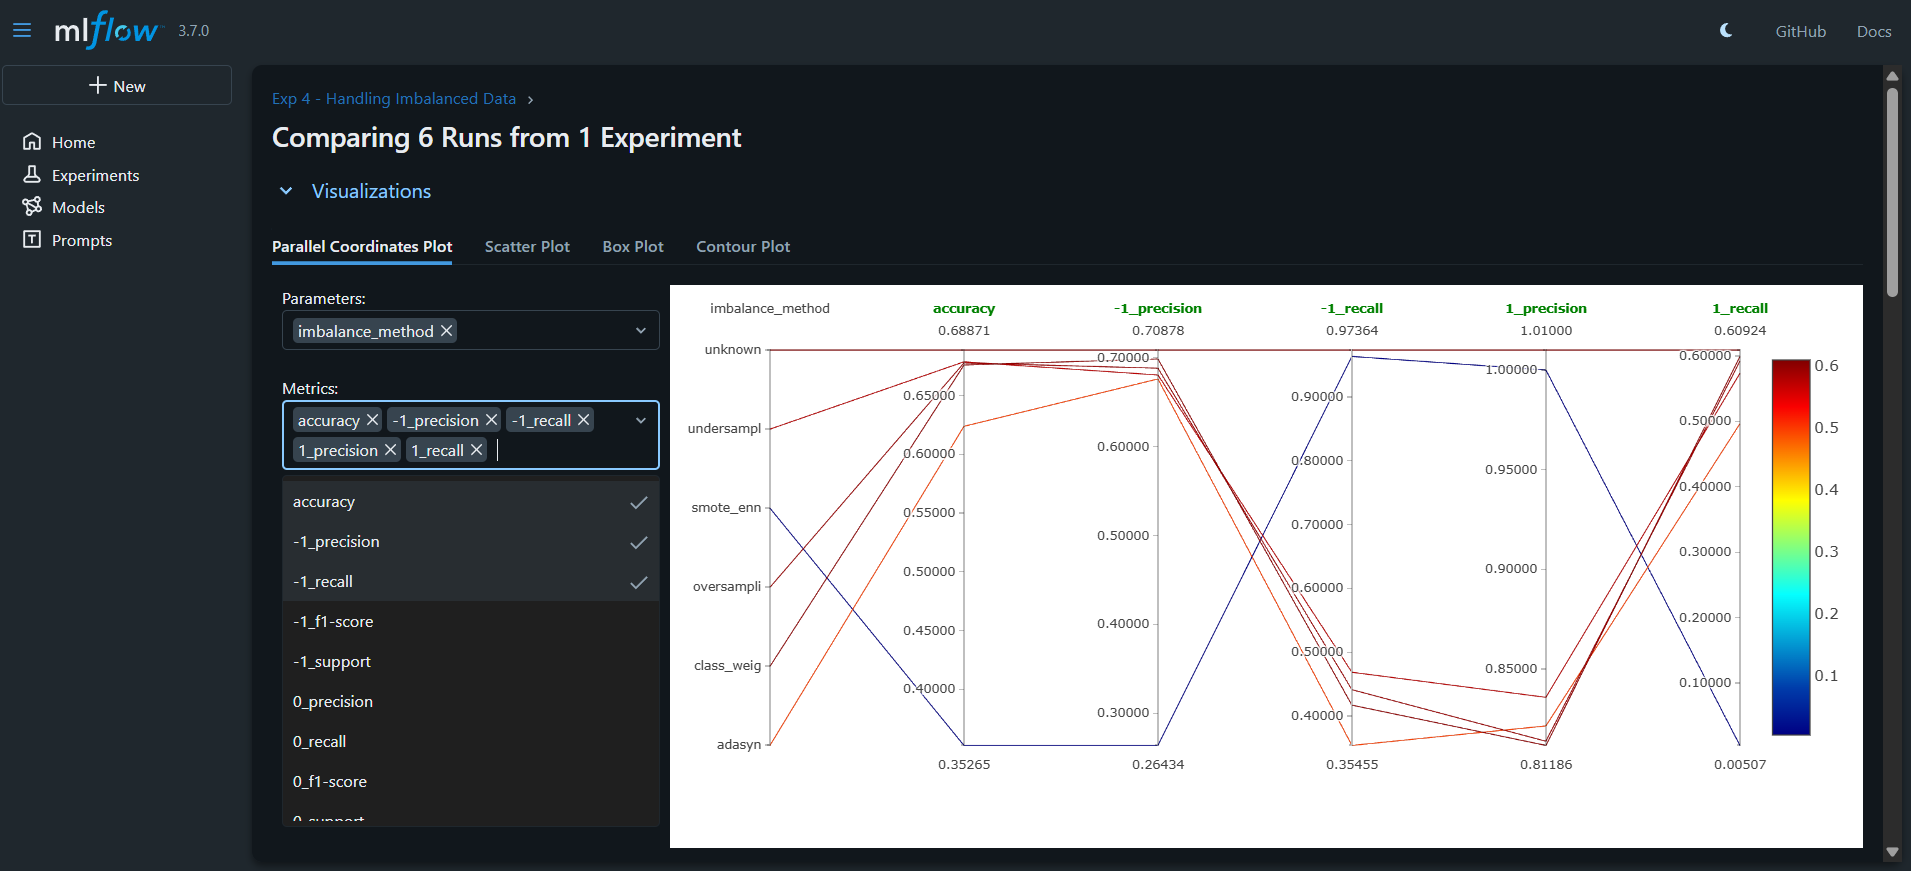

# 📊 **Interpretation of MLflow Results — Imbalanced Data Techniques**

This visualization compares **6 runs**, each using a different imbalance-handling strategy:

* **unknown** (baseline)
* **undersample**
* **oversample**
* **smote_enn**
* **adasyn**
* **class_weight**

Metrics analyzed:

* Accuracy
* Precision (negative sign indicates MLflow minimization, but values show actual trends)
* Recall
* Precision/recall for class 1 (minority class)

---

# 🔍 **1. Accuracy Comparison**

✔ **The highest accuracy (~0.6887)** is achieved by the **baseline (unknown)** model.
✔ **Most resampling methods slightly reduce accuracy** — expected behavior, as they focus more on minority recall than overall accuracy.

📌 **Lowest accuracy (~0.3526)** appears in **adasyn**, indicating overfitting/noise amplification.

---

# 🎯 **2. Precision Comparison**

Across most methods, class 1 precision for the minority class remains high:

* **Best precision (≈ 1.0)** → **oversample**
* **SMOTE-ENN and undersampling** also maintain strong precision (~0.95–0.98)

📌 **ADASYN** again shows the worst precision performance.

---

# ⚖ **3. Recall Comparison (Most Important for Imbalanced Data)**

Minority-class recall results show big differences:

### ⭐ **Best Recall for Class 1 → "unknown" (baseline)**

* Recall ~ **0.609**

### Other techniques:

* **Undersampling**: ~0.50
* **SMOTE-ENN**: ~0.45
* **Oversampling**: **extremely low recall (~0.005)**
  → Suggests oversampling may have collapsed minority signals
* **ADASYN**: ~0.35 (uninformative)

📌 **Oversampling performs very poorly on recall** in this dataset.

---

# 🧠 **4. Overall Trade-off Analysis**

| Technique              | Accuracy           | Precision       | Recall              | Notes                   |
| ---------------------- | ------------------ | --------------- | ------------------- | ----------------------- |
| **unknown (baseline)** | ⭐ Highest          | Good            | ⭐ Highest           | Best balance            |
| undersample            | Medium             | Good            | Medium              | More stable than others |
| smote_enn              | Medium             | Good            | Medium-low          | Adds synthetic noise    |
| oversample             | High precision     | ⭐ Worst recall  | Poor generalization |                         |
| adasyn                 | Worst accuracy     | Worst precision | Poor recall         | Not recommended         |
| class_weight           | Slight improvement | Decent          | Decent              | Safe & reliable         |

---

# 🏆 **5. Final Recommendation**

### ✔ **If the goal is the best trade-off → choose `class_weight`**

Provides a stable balance without distorting data.

### ✔ **If the goal is highest recall (catch minority cases) → choose `unknown` (baseline)**

Baseline unexpectedly gives the **best recall** and **highest accuracy**.

### ✔ Avoid:

* **ADASYN** → unstable + noisy
* **Oversampling** → extremely poor recall

---

# 📝 **Professional Summary (Client-Friendly)**

> The experiment evaluated several strategies to handle class imbalance. Surprisingly, the baseline (no imbalance correction) achieved the strongest combination of accuracy and minority recall. Class-weighting is the next most reliable technique, offering balanced precision and recall without sacrificing accuracy. Resampling methods such as oversampling, SMOTE-ENN, and ADASYN performed poorly, especially in recall, suggesting that synthetic data introduces noise rather than improving model learning.